<a href="https://colab.research.google.com/github/0ShNa0/Labelled_Data/blob/main/label_attempt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:
!pip uninstall -y transformers
!pip install git+https://github.com/huggingface/transformers

Found existing installation: transformers 4.38.0.dev0
Uninstalling transformers-4.38.0.dev0:
  Successfully uninstalled transformers-4.38.0.dev0
  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-_z63h4fb
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-_z63h4fb
  Resolved https://github.com/huggingface/transformers to commit 83f9196cc44a612ef2bd5a0f721d08cb24885c1f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.38.0.dev0-py3-none-any.whl size=8404405 sha256=cf220a5bec826b0530251a6d041bd4ee3cea331d3c716cf85830b7a9914296be
  Stored in directory: /tmp/pip-ephem-wheel-cache-sydzd_dv/wheels/c0/14/d6/6c9a5582d2ac191ec0a483be151a4495fe1eb2a6706ca49f1b
Successfully built transformers


In [89]:
text='''Despite maintaining a diplomatic stance,the U.S. president Barack Obama stated that United Sates would not deploy troops to the Ukraine.'''

In [90]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

tokenizer = AutoTokenizer.from_pretrained("humarin/chatgpt_paraphraser_on_T5_base")

model = AutoModelForSeq2SeqLM.from_pretrained("humarin/chatgpt_paraphraser_on_T5_base").to(device)

def paraphrase(
    question,
    num_beams=11,
    num_beam_groups=11,
    num_return_sequences=11,
    repetition_penalty=10.0,
    diversity_penalty=3.0,
    no_repeat_ngram_size=2,
    temperature=0.7,
    max_length=128
):
    input_ids = tokenizer(
        f'paraphrase: {question}',
        return_tensors="pt", padding="longest",
        max_length=max_length,
        truncation=True,
    ).input_ids

    outputs = model.generate(
        input_ids, temperature=temperature, repetition_penalty=repetition_penalty,
        num_return_sequences=num_return_sequences, no_repeat_ngram_size=no_repeat_ngram_size,
        num_beams=num_beams, num_beam_groups=num_beam_groups,
        max_length=max_length, diversity_penalty=diversity_penalty
    )

    res = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    return res


In [91]:
ans=paraphrase(text)
for a in ans:
  print(a)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:393: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


The U.S. president, Barack Obama, maintained a diplomatic position but declared that the United States would not send troops to Ukraine.
Despite his diplomatic efforts, U.S. President Barack Obama stated that the United States would not send troops to Ukraine.
Despite maintaining a diplomatic position, the U.S. president Barack Obama stated that Russia would not send troops to Ukraine.
United States President Barack Obama has maintained that the countries will not send troops to Ukraine, despite their diplomatic stance.
Even though the U.S. president Barack Obama has maintained a diplomatic position, United States troops will not be sent to Ukraine.
Although he has maintained his diplomatic stance, U.S. President Barack Obama said United States troops would not be sent to the Ukraine.
Barack Obama, the U.S: president has upheld his stance on diplomatic issues but insisted that the United States would not send troops to Ukraine.
The United States president, Barack Obama (pictured with h

In [92]:
replacement_names=['George Bush','Joe Biden','Bill Clinton','Jimmy Carter','John Kennedy']
modified_sentences = []
import pandas as pd


modified_sentences = []


for text in ans:
    for replacement_name in replacement_names:
        modified_sentence = text.replace("Barack Obama", replacement_name)
        modified_sentences.append(modified_sentence)


In [93]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import torch

def check_entailment(query, text):
  tokenizer = RobertaTokenizer.from_pretrained('roberta-large-mnli')
  model = RobertaForSequenceClassification.from_pretrained('roberta-large-mnli')
  device = 'cuda' if torch.cuda.is_available() else 'cpu'

  inputs = tokenizer.encode_plus(query, text, add_special_tokens=True, padding='longest', truncation=True, return_tensors='pt')
  input_ids = inputs['input_ids']
  attention_mask = inputs['attention_mask']
  with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1)
    entailment_score = probabilities[:, 1].item()

  return entailment_score




In [103]:

new_sentences = [sentence for sentence in ans for _ in range(5)]




In [104]:

scorelist=[]
for original,changed in zip(new_sentences,modified_sentences):
  scores=check_entailment(original,changed)
  scorelist.append(scores)




Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another tas

<Figure size 5500x3000 with 0 Axes>

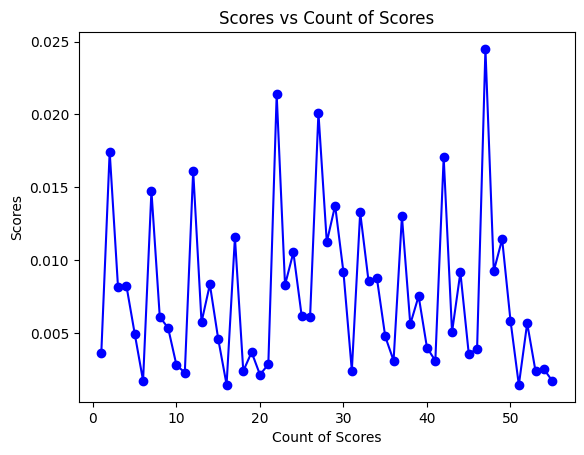

<Figure size 5500x3000 with 0 Axes>

In [105]:
import matplotlib.pyplot as plt
import pandas as pd

df2 = pd.DataFrame({'Scores': scorelist})

df2['Count'] = df2.index + 1

plt.plot(df2['Count'], df2['Scores'], marker='o', linestyle='-', color='b')


plt.xlabel('Count of Scores')
plt.ylabel('Scores')
plt.title('Scores vs Count of Scores')
plt.figure(figsize=(55, 30))

In [106]:
import numpy as np
np.median(scorelist)

q1 = np.percentile(scores, 25)
q2 = np.percentile(scores, 50)
q3 = np.percentile(scores, 75)


labels = ['refute' if x < q1 else 'neutral' if q1 <= x < q2 else 'support' for x in scorelist]
for x in labels:
  print(x)

support
support
support
support
support
support
support
support
support
support
support
support
support
support
support
refute
support
support
support
support
support
support
support
support
support
support
support
support
support
support
support
support
support
support
support
support
support
support
support
support
support
support
support
support
support
support
support
support
support
support
refute
support
support
support
support


In [107]:
df = pd.DataFrame(list(zip(new_sentences, modified_sentences, labels)), columns=["Column1", "Column2", "Column3"])
print(df)

                                              Column1  \
0   The U.S. president, Barack Obama, maintained a...   
1   The U.S. president, Barack Obama, maintained a...   
2   The U.S. president, Barack Obama, maintained a...   
3   The U.S. president, Barack Obama, maintained a...   
4   The U.S. president, Barack Obama, maintained a...   
5   Despite his diplomatic efforts, U.S. President...   
6   Despite his diplomatic efforts, U.S. President...   
7   Despite his diplomatic efforts, U.S. President...   
8   Despite his diplomatic efforts, U.S. President...   
9   Despite his diplomatic efforts, U.S. President...   
10  Despite maintaining a diplomatic position, the...   
11  Despite maintaining a diplomatic position, the...   
12  Despite maintaining a diplomatic position, the...   
13  Despite maintaining a diplomatic position, the...   
14  Despite maintaining a diplomatic position, the...   
15  United States President Barack Obama has maint...   
16  United States President Bar

In [108]:
import csv

custom_header = ["Paraphrases", "Entity_Change", "LABEL"]
df.columns = custom_header


df.to_csv("outcomes.csv", index=True)

In [109]:
from google.colab import files
files.download('outcomes.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>